**Sub Goal: Identify importance of attributes below and create predictive model for IMDb votes using them**

Variables to use:
* director
* cast / cast_freq_mean
* release_year
* country

# Initial Data Frame

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import time

# Get dataset
original_df = pd.read_csv('https://raw.githubusercontent.com/anthonybrown0528/csc-442-course-project/refs/heads/main/dataset/clean/netflix_film_imdb_data.csv')

original_df.head()

,title,description_x,release_year,runtime,imdb_id,imdb_score,imdb_votes,show_id,type,director,...,country,date_added,age_certification,num_releases,listed_in,description_y,num_listed_in,first_cast,cast_freq_mean,genre_freq_mean
0,Monty Python and the Holy Grail,"King Arthur, accompanied by his squire, recrui...",1975,91,tt0071853,8.2,530877,s4218,Movie,"Terry Gilliam, Terry Jones",...,United Kingdom,"January 2, 2019",PG,1,"Action & Adventure, Classic Movies, Comedies",The Monty Python comedy clan skewers King Arth...,3,Graham Chapman,10.888889,831.000000
1,My Fair Lady,A snobbish phonetics professor agrees to a wag...,1964,170,tt0058385,7.8,94121,s1127,Movie,George Cukor,...,United States,"April 1, 2021",G,1,"Classic Movies, Music & Musicals",When a Cockney flower girl takes elocution les...,2,Audrey Hepburn,1.083333,203.500000
2,The Blue Lagoon,Two small children and a ship's cook survive a...,1980,104,tt0080453,5.8,69053,s176,Movie,Randal Kleiser,...,United States,"September 1, 2021",R,1,"Dramas, Romantic Movies","Two shipwrecked children, stranded for years o...",2,Brooke Shields,1.375000,1446.500000
3,Bonnie and Clyde,"In the 1930s, bored waitress Bonnie Parker fal...",1967,110,tt0061418,7.7,111189,s6359,Movie,Arthur Penn,...,United States,"January 1, 2021",R,1,"Action & Adventure, Classic Movies, Dramas","Bonnie Parker and Clyde Barrow are young, in l...",3,Warren Beatty,1.777778,1076.333333
4,The Guns of Navarone,A team of allied saboteurs are assigned an imp...,1961,158,tt0054953,7.5,50150,s178,Movie,J. Lee Thompson,...,"United Kingdom, United States","September 1, 2021",TV-14,1,"Action & Adventure, Classic Movies","During World War II, British forces launch an ...",2,Gregory Peck,1.300000,459.500000


In [ ]:
# Drop all unneeded columns for query
df = original_df.drop(columns=['imdb_id', 'type', 'show_id', 'description_x', 'runtime', 'date_added', 'num_releases', 'num_listed_in', 'description_y'])
df.shape

(2477, 12)

In [ ]:
# Seperate director comma seperated values into a list for rows with multiple directors
# Must use .explode('director') to get individual directors
df['director'] = df['director'].str.split(', ')

# Create df with split director values exploded into unique rows
exploded_df = df.copy().explode('director')
exploded_df.head()

,title,release_year,imdb_score,imdb_votes,director,cast,country,age_certification,listed_in,first_cast,cast_freq_mean,genre_freq_mean
0,Monty Python and the Holy Grail,1975,8.2,530877,Terry Gilliam,"Graham Chapman, John Cleese, Eric Idle, Terry ...",United Kingdom,PG,"Action & Adventure, Classic Movies, Comedies",Graham Chapman,10.888889,831.000000
0,Monty Python and the Holy Grail,1975,8.2,530877,Terry Jones,"Graham Chapman, John Cleese, Eric Idle, Terry ...",United Kingdom,PG,"Action & Adventure, Classic Movies, Comedies",Graham Chapman,10.888889,831.000000
1,My Fair Lady,1964,7.8,94121,George Cukor,"Audrey Hepburn, Rex Harrison, Stanley Holloway...",United States,G,"Classic Movies, Music & Musicals",Audrey Hepburn,1.083333,203.500000
2,The Blue Lagoon,1980,5.8,69053,Randal Kleiser,"Brooke Shields, Christopher Atkins, Leo McKern...",United States,R,"Dramas, Romantic Movies",Brooke Shields,1.375000,1446.500000
3,Bonnie and Clyde,1967,7.7,111189,Arthur Penn,"Warren Beatty, Faye Dunaway, Michael J. Pollar...",United States,R,"Action & Adventure, Classic Movies, Dramas",Warren Beatty,1.777778,1076.333333


# Add New Columns

**Average Director Frequency**

Director: Column has some rows with comma seperated lists of directors. We must seperate them into a list in order to identify individual directors for movies with multiple directors.

In [ ]:
# Create a dictionary of all directors (key) with their # of occurrences (value)
director_occurence_dict = {}
for director in exploded_df['director']:
  if director == 'Unknown':
    continue
  if director not in director_occurence_dict:
    director_occurence_dict[director] = 1
  else:
    director_occurence_dict[director] += 1

# Calculate the average frequency of directors in each movie
title_director_freq_mean_dict = {}
for title, directors in zip(df['title'], df['director']):
  total_freq = 0
  num_directors = len(directors)

  for director in directors:
    if director != 'Unknown':
      total_freq += director_occurence_dict[director]

  title_director_freq_mean_dict[title] = total_freq / num_directors

# Map each average director frequency with the movie's associated title
df['director_freq_mean'] = df['title'].map(title_director_freq_mean_dict)
df.head()

,title,release_year,imdb_score,imdb_votes,director,cast,country,age_certification,listed_in,first_cast,cast_freq_mean,genre_freq_mean,director_freq_mean
0,Monty Python and the Holy Grail,1975,8.2,530877,"[Terry Gilliam, Terry Jones]","Graham Chapman, John Cleese, Eric Idle, Terry ...",United Kingdom,PG,"Action & Adventure, Classic Movies, Comedies",Graham Chapman,10.888889,831.000000,1.0
1,My Fair Lady,1964,7.8,94121,[George Cukor],"Audrey Hepburn, Rex Harrison, Stanley Holloway...",United States,G,"Classic Movies, Music & Musicals",Audrey Hepburn,1.083333,203.500000,1.0
2,The Blue Lagoon,1980,5.8,69053,[Randal Kleiser],"Brooke Shields, Christopher Atkins, Leo McKern...",United States,R,"Dramas, Romantic Movies",Brooke Shields,1.375000,1446.500000,1.0
3,Bonnie and Clyde,1967,7.7,111189,[Arthur Penn],"Warren Beatty, Faye Dunaway, Michael J. Pollar...",United States,R,"Action & Adventure, Classic Movies, Dramas",Warren Beatty,1.777778,1076.333333,1.0
4,The Guns of Navarone,1961,7.5,50150,[J. Lee Thompson],"Gregory Peck, David Niven, Anthony Quinn, Stan...","United Kingdom, United States",TV-14,"Action & Adventure, Classic Movies",Gregory Peck,1.300000,459.500000,1.0


**Average Country Frequency**

Country: Some movies have multiple countries in this row, we will use the proportion of the country with the highest frequency as the numeric country metric

In [ ]:
# Split and explode on country to seperate values
df['country'] = df['country'].str.split(', ')
exploded_df = df.copy()
exploded_df = exploded_df.explode('country')

# Create dictionary with countries and their proportions
country_proportions = exploded_df['country'].value_counts(normalize=True).to_dict()

# Display country proportions
exploded_df['country'].value_counts(normalize=True)

,proportion
country,
United States,0.342202
India,0.139009
United Kingdom,0.058863
France,0.037912
South Korea,0.033588
...,...
Cameroon,0.000333
Angola,0.000333
Guatemala,0.000333


In [ ]:
# Use average frequency of country for numeric value
country_freq_mean_dict = {}
for title, countries in zip(df['title'], df['country']):
    country_value_sum = 0
    for country in countries:
        country_value_sum += country_proportions[country]
    country_freq_mean_dict[title] = country_value_sum / len(countries)

# Add average country frequency to df
df['country_freq_mean'] = df['title'].map(country_freq_mean_dict)

# Display
df.head()

,title,release_year,imdb_score,imdb_votes,director,cast,country,age_certification,listed_in,first_cast,cast_freq_mean,genre_freq_mean,director_freq_mean,country_freq_mean
0,Monty Python and the Holy Grail,1975,8.2,530877,"[Terry Gilliam, Terry Jones]","Graham Chapman, John Cleese, Eric Idle, Terry ...",[United Kingdom],PG,"Action & Adventure, Classic Movies, Comedies",Graham Chapman,10.888889,831.000000,1.0,0.058863
1,My Fair Lady,1964,7.8,94121,[George Cukor],"Audrey Hepburn, Rex Harrison, Stanley Holloway...",[United States],G,"Classic Movies, Music & Musicals",Audrey Hepburn,1.083333,203.500000,1.0,0.342202
2,The Blue Lagoon,1980,5.8,69053,[Randal Kleiser],"Brooke Shields, Christopher Atkins, Leo McKern...",[United States],R,"Dramas, Romantic Movies",Brooke Shields,1.375000,1446.500000,1.0,0.342202
3,Bonnie and Clyde,1967,7.7,111189,[Arthur Penn],"Warren Beatty, Faye Dunaway, Michael J. Pollar...",[United States],R,"Action & Adventure, Classic Movies, Dramas",Warren Beatty,1.777778,1076.333333,1.0,0.342202
4,The Guns of Navarone,1961,7.5,50150,[J. Lee Thompson],"Gregory Peck, David Niven, Anthony Quinn, Stan...","[United Kingdom, United States]",TV-14,"Action & Adventure, Classic Movies",Gregory Peck,1.300000,459.500000,1.0,0.200532


# Visualization of Numeric Columns

Having made new columns to help describe the frequency of each movie's director(s), actors, and country('s), we can now use scatterplots with the y-variable being imdb_votes in order to determine if there is any visual relationship between these variables and the number of votes a movie gets.

Unfortunately, none of these variables show any real correlation. With director and actor frequency means, we'd expect the number of votes for a movie to increase based on the frequency of a certain actor or director, however, this does not seem to be the case. For both of those variables, it seems to be the opposite! Most of the high-vote movies have directors and actors with a low frequency.

The country frequency mean, release year, and genre frequency mean variables are not helpful either. Both country and genre frequency means have a pretty equal distribution of high-vote movies across high and low frequency values. Release year provide the most helpful data with just about all of the high-vote movies being after the year 2000, but this is still not very helpful because the increase in number of votes can be attributed to the boom of the movie industry around that time.

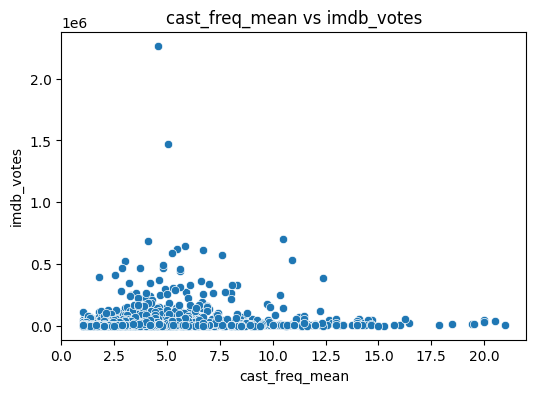

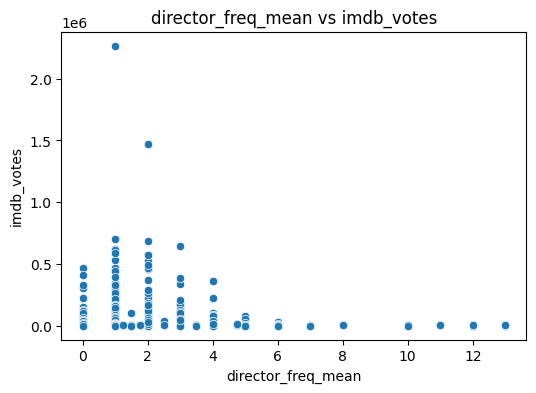

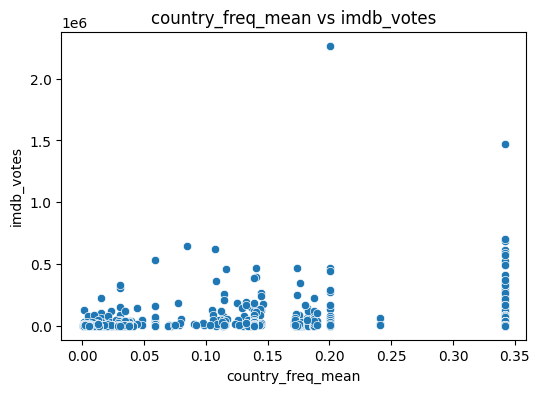

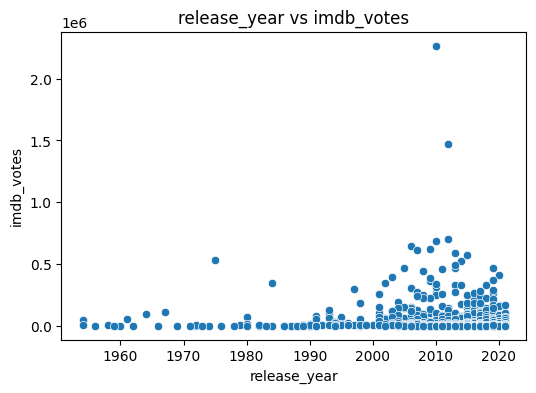

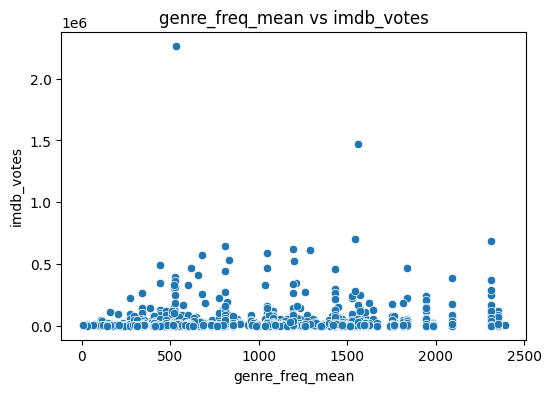

In [ ]:
# Create scatter plots for each feature vs imdb_votes
features = ['cast_freq_mean', 'director_freq_mean', 'country_freq_mean', 'release_year', 'genre_freq_mean']

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df['imdb_votes'])
    plt.title(f'{feature} vs imdb_votes')
    plt.xlabel(feature)
    plt.ylabel('imdb_votes')
    plt.show()

In [ ]:
#print(df[df['imdb_votes'] > 500000].shape)
#df[df['imdb_votes'] > 500000]

Upon looking at some of the top voted movies, movies with the director Quentin Tarantino show up as well as movies with actor Robert Downey Jr. While both of these men are in movies that have extremely high vote counts and also have many movies that they have a part in (in the real world by looking online), they do not have many occurences in this dataset which drives down their frequency averages.

Below it is shown that Quentin Tarantino and Robert Downey Jr. appear in only 2 distinct movies in all of this dataset. Furthermore, Youssef Chahine, a director out of Egypt, has 7 movies that he appears in and the highest voted movie of his is: 4385. Because of outliers like Youssef Chahine, the frequency of an actor or director appearing in a movie are unreliable for determining the number of votes a movie will get in this dataset.

In [ ]:
print(f"Youssef Chahine movie count: {df[df['director'].apply(lambda x: 'Youssef Chahine' in x)].shape[0]}")
print(f"Quentin Tarantino movie count: {df[df['director'].apply(lambda x: 'Quentin Tarantino' in x)].shape[0]}")
print("")
print(f"Robert Downey Jr. movie count: {df[df['first_cast'].apply(lambda x: 'Robert Downey Jr.' in x)].shape[0]}")
print(f"Shah Rukh Khan movie count: {df[df['first_cast'].apply(lambda x: 'Shah Rukh Khan' in x)].shape[0]}")
print("")
top_5_directors = df['director'].explode().value_counts().head(10)
print(top_5_directors)
print("")
top_5_cast = df['first_cast'].explode().value_counts().head(10)
print(top_5_cast)

Youssef Chahine movie count: 7
Quentin Tarantino movie count: 2

Robert Downey Jr. movie count: 2
Shah Rukh Khan movie count: 18

director
Unknown                596
Marcus Raboy            13
Cathy Garcia-Molina     12
Jay Karas               11
Jay Chapman             10
Ryan Polito              8
Youssef Chahine          7
Jan Suter                7
Raúl Campos              7
Justin G. Dyck           7
Name: count, dtype: int64

first_cast
Shah Rukh Khan         18
Ajay Devgn             12
Akshay Kumar           11
Shahid Kapoor          10
Aamir Khan              9
Adam Sandler            9
Amitabh Bachchan        9
Jeff Dunham             8
Kathryn Bernardo        7
Nawazuddin Siddiqui     6
Name: count, dtype: int64


# Director Average IMDb Score (Unused outside of this section)

For director average IMDb score, we are plotting it to determine any correlation between the number of votes a movie gets, and its score. Now, since this variable does not become available for a predictive model until after the movie's release, it will not be relevant in further analysis. However, I wanted to see how correlated a movie's score was with its number of votes. Based on the scatterplot, there is an obvious correlation with all of the high vote movies being in the 6-10 range for IMDb rating, but there are also very many movies in that range with a very low vote count.

In [ ]:
# Average imdb score for each director
exploded_df = df.copy().explode('director')
director_avg_score = exploded_df.groupby(exploded_df['director'].astype(str))['imdb_score'].mean().to_dict()

director_avg_score_by_title = {}

for title, directors in zip(df['title'], df['director']):
  total_score = 0
  num_directors = len(directors)

  for director in directors:
    if director != 'Unknown':
      total_score += director_avg_score[director]

  director_avg_score_by_title[title] = total_score / num_directors

df['director_avg_score'] = df['title'].map(director_avg_score_by_title)

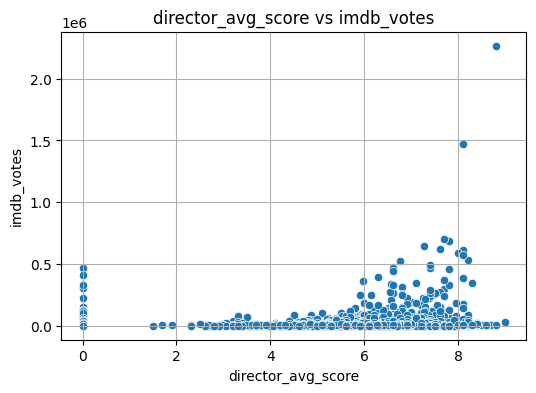

In [ ]:
feature = 'director_avg_score'
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df[feature], y=df['imdb_votes'])
plt.title(f'{feature} vs imdb_votes')
plt.xlabel(feature)
plt.ylabel('imdb_votes')
plt.grid(True)
plt.show()

# Try One-Hot Encoding for Country

Now, we will use One-Hot Encoding for the country column to get a better idea of how vote counts are distributed across countries

In [ ]:
# One-Hot encode countries and create new dataframe encoded_df
encoded_df = df.copy()
# Convert back to string
encoded_df['country'] = encoded_df['country'].apply(lambda x: ', '.join(x) if type(x) == list else x)

df_countries = encoded_df['country'].str.get_dummies(sep=', ')
encoded_df = pd.concat([encoded_df, df_countries], axis=1)
encoded_df.head(5)

,title,release_year,imdb_score,imdb_votes,director,cast,country,age_certification,listed_in,first_cast,...,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vatican City,Vietnam,West Germany,Zimbabwe
0,Monty Python and the Holy Grail,1975,8.2,530877,"[Terry Gilliam, Terry Jones]","Graham Chapman, John Cleese, Eric Idle, Terry ...",United Kingdom,PG,"Action & Adventure, Classic Movies, Comedies",Graham Chapman,...,0,0,0,1,0,0,0,0,0,0
1,My Fair Lady,1964,7.8,94121,[George Cukor],"Audrey Hepburn, Rex Harrison, Stanley Holloway...",United States,G,"Classic Movies, Music & Musicals",Audrey Hepburn,...,0,0,0,0,1,0,0,0,0,0
2,The Blue Lagoon,1980,5.8,69053,[Randal Kleiser],"Brooke Shields, Christopher Atkins, Leo McKern...",United States,R,"Dramas, Romantic Movies",Brooke Shields,...,0,0,0,0,1,0,0,0,0,0
3,Bonnie and Clyde,1967,7.7,111189,[Arthur Penn],"Warren Beatty, Faye Dunaway, Michael J. Pollar...",United States,R,"Action & Adventure, Classic Movies, Dramas",Warren Beatty,...,0,0,0,0,1,0,0,0,0,0
4,The Guns of Navarone,1961,7.5,50150,[J. Lee Thompson],"Gregory Peck, David Niven, Anthony Quinn, Stan...","United Kingdom, United States",TV-14,"Action & Adventure, Classic Movies",Gregory Peck,...,0,0,0,1,1,0,0,0,0,0


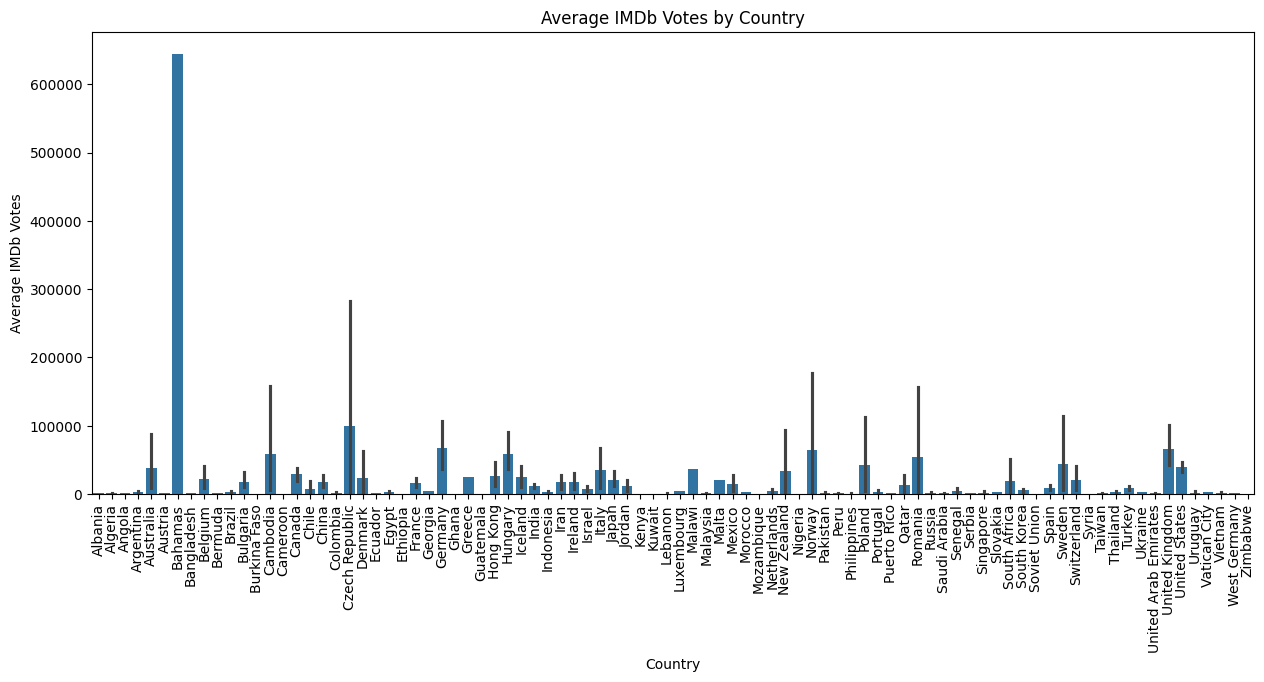

In [ ]:
# Plot the average IMDb vote counts for movies by country
melted_df = pd.melt(encoded_df, id_vars=['imdb_votes'], value_vars=df_countries.columns, var_name='country', value_name='isCountry')
melted_df = melted_df[melted_df['isCountry'] == 1]
melted_df = melted_df.drop(columns=['isCountry'], ).reset_index(drop=True)

plt.figure(figsize=(15, 6))
sns.barplot(x='country', y='imdb_votes', data=melted_df)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average IMDb Votes')
plt.title('Average IMDb Votes by Country')
plt.show()

In [ ]:
melted_df[melted_df['imdb_votes']==644336]
melted_df.head()

,imdb_votes,country
0,1573,Albania
1,443,Algeria
2,1020,Algeria
3,977,Angola
4,6249,Argentina


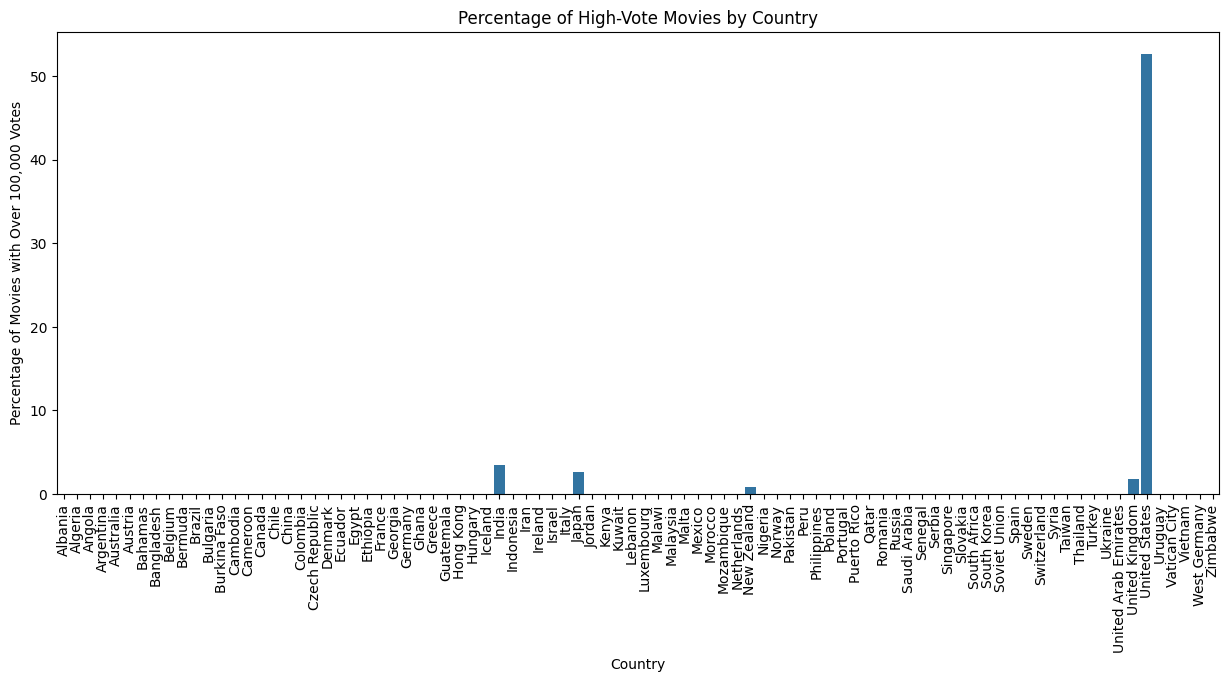

In [ ]:
# Show percentage of movies over a certain vote count by country
min_votes = 100000

encoded_filtered_df = encoded_df[encoded_df['imdb_votes'] > min_votes]
total_movies = encoded_filtered_df.shape[0]

percentage_dict = {}
for country in df_countries.columns:
    high_vote_movies = encoded_filtered_df[encoded_filtered_df['country'] == country].shape[0]
    percentage_dict[country] = (high_vote_movies / total_movies) * 100

percentage_df = pd.DataFrame(list(percentage_dict.items()), columns=['country', 'percentage'])


plt.figure(figsize=(15, 6))
sns.barplot(x='country', y='percentage', data=percentage_df)
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Percentage of Movies with Over 100,000 Votes')
plt.title('Percentage of High-Vote Movies by Country')
plt.show()

# Actual Query Standalone

In [ ]:
# Query in Full

# Time start
start_time = time.time()

percentage_dict = {}
for country in df_countries.columns:
    high_vote_movies = encoded_filtered_df[encoded_filtered_df['country'] == country].shape[0]
    percentage_dict[country] = (high_vote_movies / total_movies) * 100

percentage_df = pd.DataFrame(list(percentage_dict.items()), columns=['country', 'percentage'])

# Time stop
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

percentage_df.head(50)

Elapsed time: 0.0493 seconds


,country,percentage
0,Albania,0.000000
1,Algeria,0.000000
2,Angola,0.000000
3,Argentina,0.000000
4,Australia,0.000000
5,Austria,0.000000
6,Bahamas,0.000000
7,Bangladesh,0.000000
8,Belgium,0.000000
9,Bermuda,0.000000
